## Data generator example
---

Example showing how to create a PyTorch compatible generator which windows trace data and applies standard data augmentation steps. 

Data generation API also uses function-based decorators to allow user to easily construct data augmentation and processing pipelines. Example usage is also shown below.

***Current version of the data generator code is incomplete and subject to change**

In [1]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seisbench.data
import numpy as np

Get dummy dataset:

In [2]:
dummy = seisbench.data.DummyDataset()
print(dummy)

DummyDataset - 100 traces


In [3]:
dummy.metadata

,trace_start_time,source_latitude_deg,source_longitude_deg,source_depth_km,source_event_category,source_magnitude,source_magnitude_uncertainty,source_magnitude2,source_magnitude_uncertainty2,trace_name,station_network_code,station_code,station_type,station_latitude_deg,station_longitude_deg,station_elevation_m,source_magnitude_type,source_magnitude_type2,trace_chunk,trace_sampling_rate_hz
0,2007/01/01 01:42:45.08,-20.43802,-69.27681,83.18,ID,1.353,0.014,1.426,0.011,2007_01_01 01_42_45_08,CX,PB01,BH,-21.04323,-69.4874,900.0,MA,ML,,20
1,2007/01/01 02:41:13.75,-21.64059,-68.41443,118.38,ID,1.981,0.020,2.027,0.023,2007_01_01 02_41_13_75,CX,PB01,BH,-21.04323,-69.4874,900.0,MA,ML,,20
2,2007/01/01 03:50:29.27,-21.84637,-68.53904,111.82,ID,2.719,0.024,2.811,0.026,2007_01_01 03_50_29_27,CX,PB01,BH,-21.04323,-69.4874,900.0,MA,ML,,20
3,2007/01/01 05:40:02.55,-21.23950,-70.05063,34.95,UP,2.169,0.020,2.269,0.020,2007_01_01 05_40_02_55,CX,PB01,BH,-21.04323,-69.4874,900.0,MA,ML,,20
4,2007/01/01 05:52:18.43,-21.81511,-68.65773,106.69,ID,2.028,0.021,2.080,0.024,2007_01_01 05_52_18_43,CX,PB01,BH,-21.04323,-69.4874,900.0,MA,ML,,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2007/01/07 05:19:53.63,-21.02248,-68.96970,109.05,ID,1.464,0.016,1.513,0.021,2007_01_07 05_19_53_63,CX,PB01,BH,-21.04323,-69.4874,900.0,MA,ML,,20
96,2007/01/07 05:25:44.43,-20.06507,-69.15500,93.64,ID,1.606,0.024,1.660,0.026,2007_01_07 05_25_44_43,CX,PB01,BH,-21.04323,-69.4874,900.0,MA,ML,,20
97,2007/01/07 06:37:03.33,-21.13000,-68.90223,110.59,ID,1.530,0.012,1.574,0.013,2007_01_07 06_37_03_33,CX,PB01,BH,-21.04323,-69.4874,900.0,MA,ML,,20
98,2007/01/07 06:39:20.08,-21.26966,-68.73751,120.06,ID,3.514,0.035,3.584,0.032,2007_01_07 06_39_20_08,CX,PB01,BH,-21.04323,-69.4874,900.0,MA,ML,,20


In [4]:
dummy.metadata['trace_p_arrival_sample'] = 500
dummy.metadata['trace_s_arrival_sample'] = 300

for i, p_arr, s_arr in zip(np.arange(5), [320, 480, 490, 220, 440], [540, 880, 810, 380, 740]):
    dummy.metadata['trace_p_arrival_sample'][i] = p_arr
    dummy.metadata['trace_s_arrival_sample'][i] = s_arr

dummy.metadata['trace_g_arrival_sample'] = np.nan


C:\Users\jwool\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\jwool\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
from seisbench.generate import GenericGenerator, SlidingWindow, Normalize, Filter, FixedWindow, PickLabeller
generator = GenericGenerator(dataset=dummy)
generator

In [6]:
first_arrival = 1

print(first_arrival if 0 else True)

True


Apply some simple processing steps. The ```GenericGenerator``` instance takes a single required argument _dataset_ (a SeisBench dataset), and makes it compatible with and inherit the functionality a PyTorch Dataset object. This allows you to wrap the GenericGenerator in a PyTorch DataLoader the same as any other PyTorch Dataset class - giving multiprocessing, batch-loading, shuffling functionality.

Internally, ```GenericGenerator``` also ensures any processing methods applied are tracked through the objects state. Processing operations are applied recursively when __getitem__ is called. All users' need to do pass their augmentations to ```generator.augmentation``` or use the ```@generator.augmentation``` decorator.

Below we add some standard processing steps to apply to the raw waveform data. For each processing step, the method modifies the _state_dict_ which is naturally a dictionary of the current objects state up until this point. We use three customizable augmentations from the SeisBench library and one self implemented augmentation.

In [7]:
generator.augmentation(Filter(1, 0.5, "highpass", forward_backward=True))
generator.augmentation(SlidingWindow(timestep=300, windowlen=600))
generator.augmentation(Normalize(demean_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"))
generator.augmentation(PickLabeller(dim=0, on_overlap='fixed-relavance'))

@generator.augmentation
def times_two(state_dict):
    # Scale the waveforms by a factor of two inplace
    x = state_dict['X'][0]
    x *= 2



In [8]:
generator._augmentations[2].__dict__

{'demean_axis': -1,
 'detrend_axis': None,
 'amp_norm_axis': -1,
 'amp_norm_type': 'peak',
 'eps': 1e-10,
 'key': ('X', 'X')}

As dicussed, wrap dataset in PyTorch DataLoader yielding batches of 5 example waveforms each time. Each example will have processing steps applied (so should be 600 sample windows, stepped along).

In [9]:
# Wrap generator in PyTorch DataLoader
train_loader = torch.utils.data.DataLoader(
    dataset=generator, 
    batch_size=5, 
    pin_memory=True, 
    shuffle=False
)

In [10]:
a = np.array([[ True, False, False],
 [ True,  True, False],
 [ True,  True,  True]])

for i in range(3):
    non_null_columns =np.argwhere(~a[i])
    if non_null_columns.size > 0:
        print(non_null_columns)
        print(np.random.choice(non_null_columns.reshape(-1)) + 1)

[[1]
 [2]]
2
[[2]]
3


Each call of ```__getitem__``` adds training and label data to the state_dict which is then returned upon each iteration of the dataloader. 

In [11]:
for train_data in train_loader:
    break

train_data['X'].shape

torch.Size([5, 3, 3, 600])

You can also see what processing methods were applied directly in the GenericGenerator

In [12]:
print(generator)

GenericGenerator with 5 augmentations:
 1.	Filter (highpass, order=1, frequencies=0.5, analog=False, forward_backward=True, axis=-1)
 2.	SlidingWindow (windowlen=600, timestep=300)
 3.	Normalize (Demean (axis=-1), Amplitude normalization (type=peak, axis=-1))
 4.	PickLabeller (label_type=multi_class, dim=0)
 5.	<function times_two at 0x0000015BD5F72288>



In [13]:
a = np.array([[0, 0], [np.nan, 1], [1, 1]])

np.argwhere(~np.isnan(a))

array([[0, 0],
       [0, 1],
       [1, 1],
       [2, 0],
       [2, 1]], dtype=int64)

Compress along batch dimension for plotting...

In [14]:
def compress_batch_dim(t):
    """
    Utility function to stack tensor data along batch dim.
    :param t: tensor, format (B, N, W, C)
    :type t: torch.Tensor
    :return : t: tensor, format (N, C, W)
    """
    return t.reshape(-1, t.shape[2], t.shape[3])


for train_data in train_loader:
    print('PyTorch DataLoader format:\n\t[B, N, C, W]\n')
    print('-->', train_data['X'].shape)
    
    train_data['X'] = compress_batch_dim(train_data['X'])
#     train_data['y'] = compress_batch_dim(train_data['y'])
    train_data['y'] = train_data['y'].flatten()
    print('\nCompressed windows along batch dim (now [N, C, W])\n')
    print('-->', train_data['X'].shape)
    break

PyTorch DataLoader format:
	[B, N, C, W]

--> torch.Size([5, 3, 3, 600])

Compressed windows along batch dim (now [N, C, W])

--> torch.Size([15, 3, 600])


Plot all training examples (no processing applied to windowed traces). **P and S labels not provided in dummy dataset so placeholder values used.** I match up the first trace to the trace_p_sample, trace_s_sample picks so the windows that step along the first trace should match up.. and when there are no longer any phases in the trace this should also match up. For the remaining windowed traces, this will no longer be the case as I am using dummy variables for now. To be completed.

In [15]:
train_data['y'].flatten()
# generator._augmentations[-2].label_tags

tensor([2., 3., 0., 2., 2., 3., 2., 2., 3., 2., 3., 0., 2., 3., 3.],
       dtype=torch.float64)

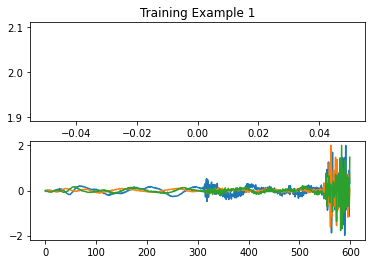

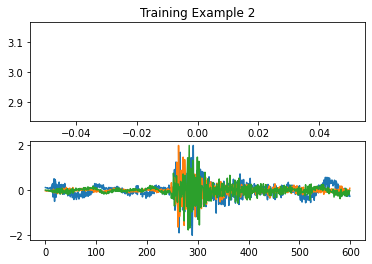

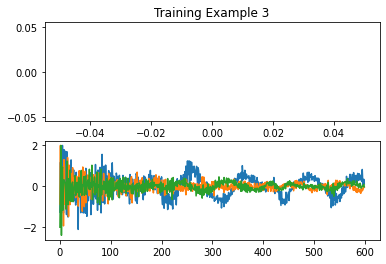

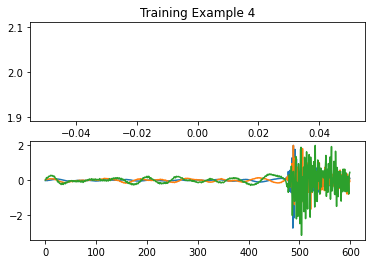

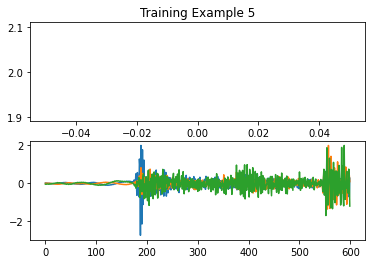

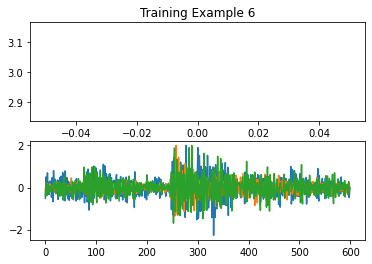

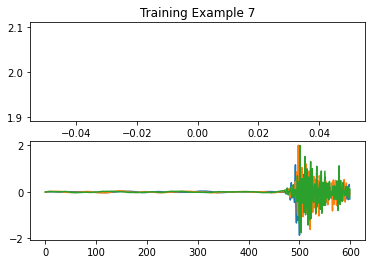

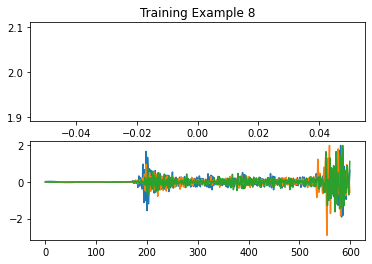

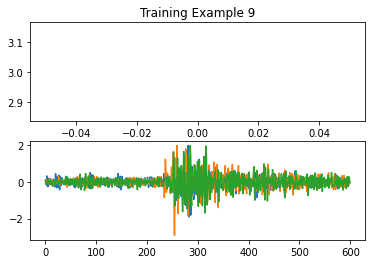

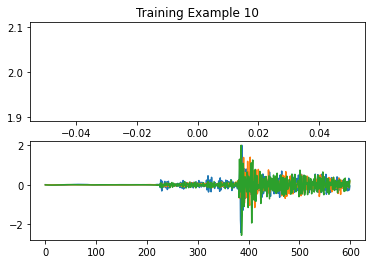

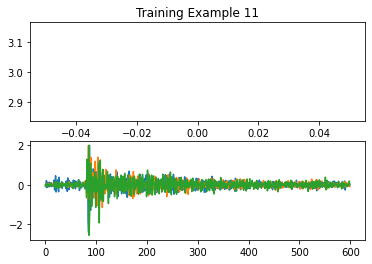

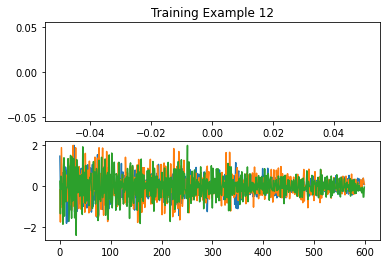

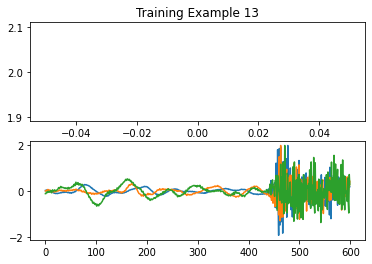

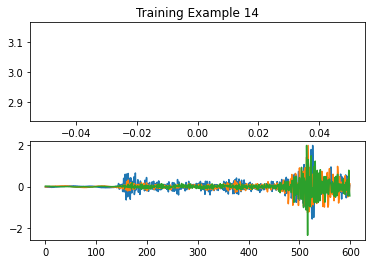

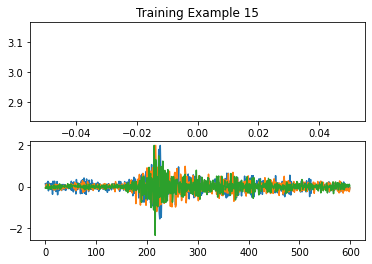

In [16]:
for i, (train, label) in enumerate(zip(train_data['X'], train_data['y'])):
    plt.figure()
    plt.subplot(211)
    plt.title(f'Training Example {i+1}')
    plt.plot(label.T)
    plt.subplot(212)
    plt.plot(train.T)
    plt.show()